In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils

# Uninverted/ Inverted 2D Court (x,y) Coordinates

Four Corners:
- bottom left, top left, bottom right, top right
- uninvert - [(0, 400), (0, 0), (600, 400), (600, 0)]
- invert - [(0, 400), (0, 0), (600, 400), (600, 0)]

Free Throw Section:
- bottom left, top left, bottom right, top right
- uninvert - [(226, 400), (226, 240), (394, 400), (394, 240)]
- invert - [(226, 160), (226, 0), (370, 160), (370, 0)]

Three Point Arc Section 
- left, center, right
- uninvert - [(63, 400), (300, 185), (535, 400)]
- invert - [(63, 0), (300, 216), (535, 0)]

# Player Position Extraction using Using Hough Transform Algorithm 

<Figure size 720x576 with 0 Axes>

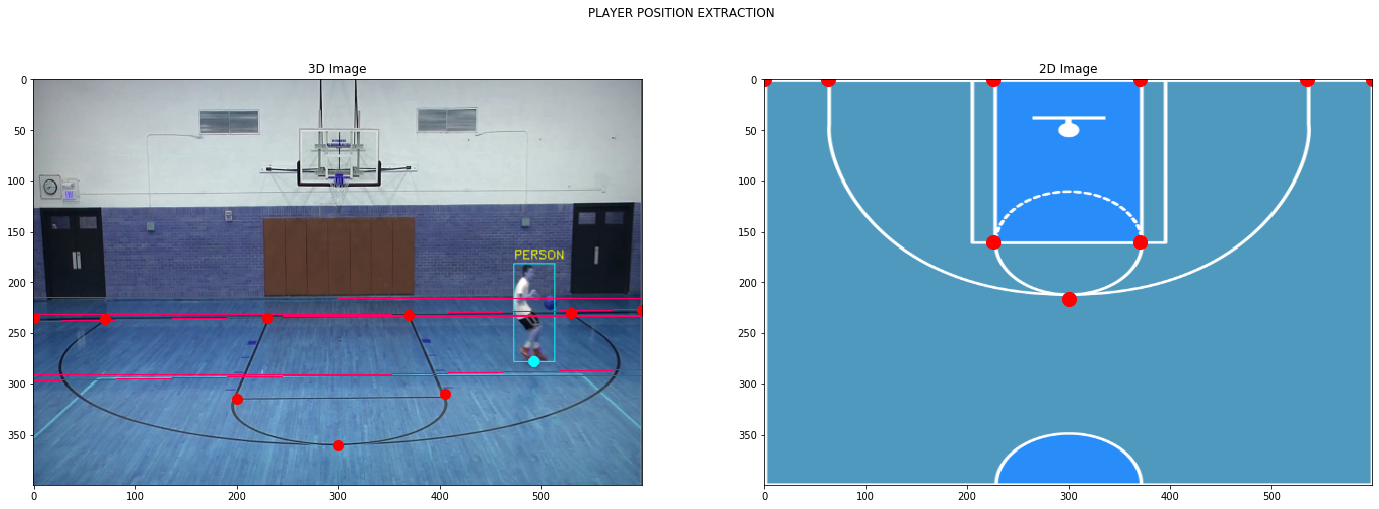

In [14]:
plt.figure(figsize=(10,8))

pts_3D = np.array([(0,235), (70, 236), (230, 235), (370, 232), (530, 230), (600, 227), (300, 360), (200, 315), (405, 310)])
pts_2D = np.array([(0, 0), (63, 0),(226, 0), (370, 0), (535, 0), (600, 0), (300, 216), (226, 160), (370, 160) ])

frame = cv2.imread('/Users/esedicol/Desktop/Basketball-Shot-Detectection/images/court/court_extraction.png')
frame  = cv2.resize(frame, (600,400))

inverted_court = cv2.imread('/Users/esedicol/Desktop/Basketball-Shot-Detectection/images/court/court_invert.png')
inverted_court  = cv2.resize(inverted_court, (600,400))

roi = frame[150:400, 0: 600]

r_h, r_w, r_c = roi.shape
i_h, i_w, i_c = frame.shape

# line detection works better with grayscale images (less pixel range to process)
gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)

# Canny edge detection to detect line edges
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# calculate (x1,y1) and (x2, y2) coordinates
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    # extend lines out 
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    cv2.line(frame, (x1, y1 + (i_h - r_h)), (x2, y2 + (i_h - r_h)), (255, 0 ,100), 1)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle("PLAYER POSITION EXTRACTION")

ax1.set_title("3D Image")
for p in range(0, len(pts_3D)):
    ax1.scatter(pts_3D[p][0], pts_3D[p][1], s=100, c='r', marker='o')

ax2.set_title("2D Image")
for p in range(0, len(pts_2D)):
    ax2.scatter(pts_2D[p][0], pts_2D[p][1], s=200, c='r')
    
ax1.imshow(frame)
ax2.imshow(inverted_court)
plt.show()

In [4]:
matrix, status = cv2.findHomography(pts_3D, pts_2D)
warped_frame = cv2.warpPerspective(frame, matrix, (inverted_court.shape[1], inverted_court.shape[0]))

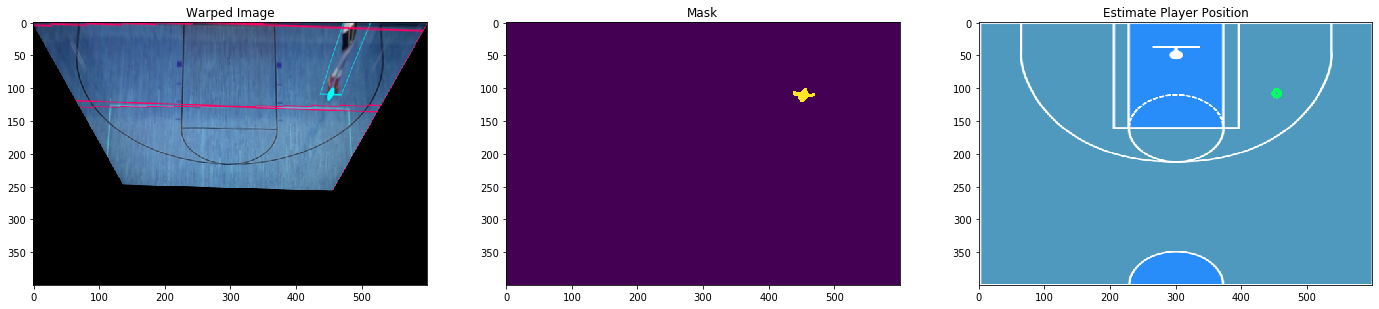

In [13]:
lower_range = (10, 160, 160)                       
upper_range = (100,255,255)  

def estimate_position(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    blur = cv2.GaussianBlur(frame, (15, 15),0)
    erode = cv2.erode(blur, None, iterations=2)
    dilate = cv2.dilate(erode, None, iterations=2)
    hsv = cv2.cvtColor(dilate, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_range, upper_range)  

    cnts = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    c = max(cnts, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)

    if radius > 5:
        cv2.circle(inverted_court, (int(x), int(y)), 5, (0, 255, 100), 5) 

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    
    ax1.set_title("Warped Image")
    ax2.set_title("Mask")
    ax3.set_title("Estimate Player Position")

    ax1.imshow(warped_frame)
    ax2.imshow(mask)
    ax3.imshow(inverted_court)
    plt.show()
    
estimate_position(warped_frame)